# Proof of concept, GLMdenoise

Let's generate some data:

\begin{align}
y = X\beta + \epsilon, \epsilon \sim N(0, 1)
\end{align}

In [3]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from nistats.design_matrix import make_design_matrix
from nistats.reporting import plot_design_matrix
from itertools import compress
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Generate data
data is list of runs, where each run is x * y * z * TRs

In [79]:
def rsquared(y, yhat):
    with np.errstate(divide='ignore', invalid='ignore'):
        return 1 - (np.sum((y - yhat)**2, axis=0) / np.sum((y - y.mean(axis=0))**2, axis=0))

In [23]:
ii=1
y = np.load(f'data/sub_sub-01_slice_15_run_{ii:02d}.npy')
y.T.shape

(641, 80, 80)

In [28]:
y = y.T
y.reshape([y.shape[0], -1]).shape

(641, 6400)

In [63]:
data = []
design = []
n_runs = 2

for ii in range(n_runs):
    y = np.load(f'data/sub_sub-01_slice_15_run_{ii+1:02d}.npy').T
    y = y.reshape([y.shape[0], -1])
    
    stimdur = 0.5
    TR = 0.764
    n_scans = y.shape[0]
    frame_times = np.arange(n_scans) * TR
    
    # Load onsets and item presented
    onsets = pd.read_csv(f'data/sub_sub-01_slice_15_run_{ii+1:02d}.csv')['onset'].values
    items = pd.read_csv(f'data/sub_sub-01_slice_15_run_{ii+1:02d}.csv')['item'].values
    n_events = len(onsets)

    # Create design matrix
    events = pd.DataFrame()
    events['duration'] = [stimdur]*n_events
    events['onset'] = onsets
    events['trial_type'] = items

    X = make_design_matrix(
        frame_times, events, hrf_model='glover', drift_order=3, drift_model='polynomial')

    data.append(y)
    design.append(X.values)


In [84]:
a = np.array(r2s).mean(0)

In [88]:
sum(np.isnan(a))

466

In [80]:
b = rsquared(np.vstack(data),np.vstack(preds))

In [ ]:
b

In [78]:
print(np.vstack(preds).shape)
print(np.vstack(data).shape)

(1282, 6400)
(1282, 6400)


/Users/daniel/anaconda/lib/python3.6/site-packages/matplotlib/axes/_base.py:2324: RuntimeWarning: overflow encountered in double_scalars
  x0t -= delta


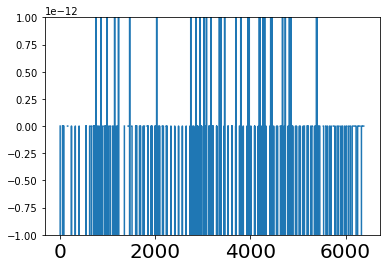

In [95]:
plt.plot(np.nan_to_num(a))

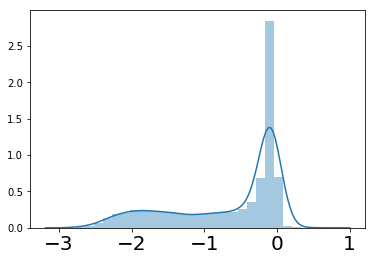

In [91]:
import seaborn as sns
a[a == np.inf] = 0
sns.distplot(np.nan_to_num(a), color='green')
sns.distplot(np.nan_to_num(b))

In [67]:
tmpy.shape

(641, 6400)

In [83]:
# cross-validate and get r-score for each voxel
r2s = []
preds =[]
for run in range(n_runs):
    # fit data using all the other runs
    mask = np.arange(n_runs) != run
    tmpy = np.vstack(compress(data, mask))
    tmpX = np.vstack((compress(design, mask)))
    
    betas_tmp = np.linalg.lstsq(tmpX, tmpy,  rcond=False)[0]
    
    # left out data
    yhat = design[run].dot(betas_tmp)
    rsq2 = rsquared(data[run], yhat)
    r2s.append(rsq2)
    preds.append(yhat)
    
    
    
    

In [42]:
betas_est = np.linalg.lstsq(X, y, rcond=False)[0]
yhat = X.dot(betas_est)
noise = y - yhat
rsq2 = 1 - (np.sum((y - yhat)**2, axis=0) / np.sum((y - y.mean(axis=0))**2, axis=0))
rsq = 1 - (np.sum((y - yhat)**2, axis=0) / np.sum(y**2, axis=0))

### Calculate variance across betas
\begin{align}
var(\beta) = \sigma^2(X^1X)^{-1}
\end{align}
### Where
\begin{align}
\sigma = \frac{\sum_{i=1}^K(y_i - yhat_i)^2}{N-P}
\end{align}

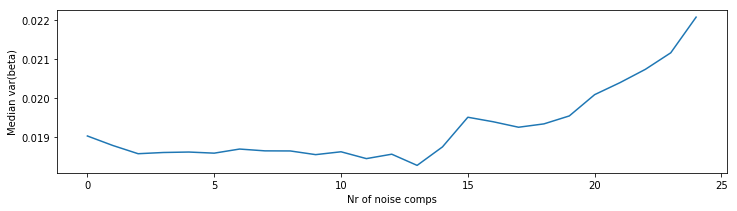

In [44]:
N_np = 49 # size of noise pool
noise_mask = np.zeros(K).astype(bool)
idx = np.argsort(rsq)[:N_np] # sort voxels after r square
noise_mask[idx] = True
noise_pool = y[:, idx]
pcas = PCA().fit_transform(noise_pool)
y_non_np = y[:, np.invert(idx)] # voxels not in the noise pool
    
median_var_betas = np.zeros(N_np)
plt.figure(figsize=(12, 3))
for i, n_pca in enumerate(np.arange(1, idx.size+1)):
    # Add n PCs to design matrix
    Xtmp = np.c_[X, pcas[:, :n_pca]]
    # Fit data
    betas_tmp = np.linalg.lstsq(Xtmp, y_non_np)[0]
    yhat_tmp = Xtmp.dot(betas_tmp)
    # calculate variance
    sigsq_tmp = np.sum((y_non_np - yhat_tmp)**2, axis=0) / (N - Xtmp.shape[1])
    des_var_tmp =  np.diagonal(np.linalg.inv(Xtmp.T.dot(Xtmp)))
    var_betas = sigsq_tmp * des_var_tmp[:, np.newaxis]
    median_var_betas[i] = np.median(var_betas)

plt.plot(median_var_betas[:25])
plt.xlabel('Nr of noise comps')
plt.ylabel('Median var(beta)')
plt.show()